# Kessler Rules model for Sorted Circles

In [1]:
import numpy as np
from scipy.signal import convolve2d

#Plotting
import matplotlib.pyplot as plt
from matplotlib import colors,cm

#importing solver functions and plotting scripts
from functions import *
from plotting import *

## Setting up the Grids
Only work in 2-D case for now. Small test case

In [2]:
# Setting constants
nx = 5
nz = 10
dx,dz = 0.2,0.1
atm_thickness = 5

T_a = -40 #temperature of atmosphere
T_0 = 2 #Temperature of soil initially
h_stones = 1 # thickness of stone layer
compressibility = 0.2 #compresssiblitityof soil (represented as fraction of void cells in fines domain)
rho_water = 1000 #density kg/m3
rho_fines = 1600 #density kg/m3

# Heat capacity and specific heat:
cp_fines = 800 #J/kg/C for dry sand
cp_water = 4186 #J/kg/C
cp_wet = 1480 #J/kg/C
L_fusion = 333.55*1000 #J/kg

# thermal diffusivities
kappa_fines = 1e-5 
kappa_stones = 1e-3
kappa_ice = 1e-7
kappa_atmosphere = 1e-7

In [3]:


#create initial arrays:
temp_arr = np.zeros((nz,nx)) #array for temperature
type_arr = np.zeros_like(temp_arr).astype('str')
kappa_arr = np.zeros_like(temp_arr) # array holding diffusivity of each cell

#set type array:
type_arr[:atm_thickness,:] = 'a'
type_arr[atm_thickness:atm_thickness+h_stones,:] = 's'
type_arr[atm_thickness+h_stones:,:] = 'f'

# add voids at random spaces based on type
n_voids = int(np.sum(type_arr == 'f')*compressibility)
void_indx = [(np.random.randint(atm_thickness+h_stones,len(type_arr)),np.random.randint(0,len(type_arr[0]))) for _ in range(n_voids)]
for i in void_indx:
    type_arr[i] = 'v'

type_arr

array([['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['s', 's', 's', 's', 's'],
       ['f', 'f', 'f', 'v', 'v'],
       ['f', 'f', 'v', 'f', 'f'],
       ['f', 'f', 'f', 'f', 'f'],
       ['f', 'f', 'f', 'v', 'f']], dtype='<U32')

In [4]:
def set_arrays(type_arr,diff_arr,temp_arr,heat_arr,kappa_atm,kappa_fines,kappa_stones,T_a,T_0,heat_initial):
    '''Set diffusivity, temperature and latent heat arrays for the next freezing cycle'''
    mapping_dict = {'a': [kappa_atm,T_a,0],'v':[kappa_atm,T_0,0],'f':[kappa_fines,T_0,heat_initial],'s':[kappa_stones,T_0,0]}
    for key in mapping_dict:
        diff_arr[type_arr == key] = mapping_dict[key][0]
        temp_arr[type_arr == key] = mapping_dict[key][1]
        heat_arr[type_arr == key] = mapping_dict[key][2]
    
    return diff_arr,temp_arr,heat_arr

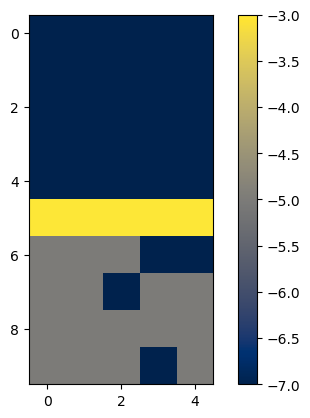

In [5]:
# set thermal diffusivity array:
kappa_arr[type_arr == 'a'] = kappa_atmosphere
kappa_arr[type_arr == 'v'] = kappa_atmosphere
kappa_arr[type_arr == 's'] = kappa_stones
kappa_arr[type_arr == 'f'] = kappa_fines

plt.imshow(np.log10(kappa_arr),cmap='cividis')
plt.colorbar();

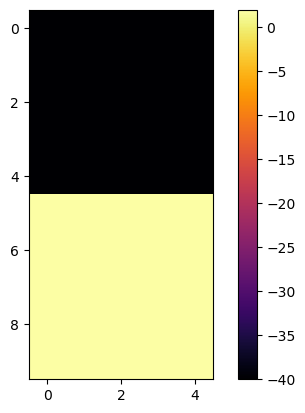

In [6]:
# set initial Temperature array:
temp_arr[type_arr=='a'] = T_a
temp_arr[type_arr !='a'] = T_0

plt.imshow(temp_arr,cmap='inferno')
plt.colorbar();

In [7]:
# pad each array to have a constant boundary
temp_arr_pad = np.pad(temp_arr,mode='edge',pad_width=1)
temp_arr_pad[-1,:] = -2

type_arr_pad = np.pad(type_arr,1,mode='constant',constant_values='b')

kappa_arr_pad = np.pad(kappa_arr,1,mode='edge')
print(type_arr_pad.shape)
type_arr_pad[1,6]

(12, 7)


'b'

In [8]:
kappa_arr_pad_original = kappa_arr_pad.copy()
type_arr_pad_original = type_arr_pad.copy()
temp_arr_pad_original = temp_arr_pad.copy()

## Temperature Diffusion
The Heat equation is given by:
$\frac{\partial T}{\partial t} = \kappa \nabla^2T  \\$
Discretised for 2 dimensions and using FTCS this gives 
$\Delta T_{i,j} = \kappa \Delta t (\frac{T_{i-1,j}^n - 2T_{i,j}^n+T_{i+1,j}^n}{\Delta x^2} + \frac{T_{i,j-1}^n - 2T_{i,j}^n+T_{i,j+1}^n}{\Delta z^2}$)

In [9]:
dt = min(dx**2/(8*kappa_stones),dz**2/(8*kappa_stones))
print(dt)

def solve_heat2D(T,type,kappa, dt=dt,dx=dx,dz=dz,nx=nx,nz=nz):
    dT_arr = np.zeros_like(T)
    for i in range(1, nx+1):
        for j in range(1,nz+1):
            if type[j,i] == 'a' or type[j,i] == 'b': #ignore atomsphere and boundary cells
                continue
            else:
                dTdx = (T[j,i-1] - 2*T[j,i] + T[j,i+1]) / (dx**2) # calculate T difference in  x
                dTdz = (T[j-1,i] - 2*T[j,i] + T[j+1,i]) / (dz**2) # calculate T difference in z
                
                dT_arr[j,i] = kappa[j,i]*dt*(dTdx+dTdz)

    return dT_arr

1.2500000000000002


### Testing diffusion equation on its own

In [10]:
'''
# Uncomment to run heat diffusion without latent heat conversion

nt = int(400000/dt)+1
print(nt)
for _ in range(nt):
    temp_arr_pad += solve_heat2D(temp_arr_pad,type_arr_pad,kappa_arr_pad)

    
fig,ax = plt.subplots(1,2)

ax[0].imshow(temp_arr_pad_original,cmap='inferno')
im = ax[1].imshow(temp_arr_pad,cmap='inferno')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax,label='Temperature(C)');    
'''

"\n# Uncomment to run heat diffusion without latent heat conversion\n\nnt = int(400000/dt)+1\nprint(nt)\nfor _ in range(nt):\n    temp_arr_pad += solve_heat2D(temp_arr_pad,type_arr_pad,kappa_arr_pad)\n\n    \nfig,ax = plt.subplots(1,2)\n\nax[0].imshow(temp_arr_pad_original,cmap='inferno')\nim = ax[1].imshow(temp_arr_pad,cmap='inferno')\nfig.subplots_adjust(right=0.8)\ncbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])\nfig.colorbar(im,cax=cbar_ax,label='Temperature(C)');    \n"

### Add Latent heat conversion

In [11]:
# Create array of amount of heat needed for full conversion of water to ice:
Q_needed = compressibility*(dz*dx**2)*rho_water*L_fusion # Heat needed for a cell of all porous space filled by water

heat_arr_initial = np.zeros_like(temp_arr_pad)
heat_arr_initial[type_arr_pad=='f'] = Q_needed #set fines cells in heat array to the initial heat needed for fusion

In [12]:
'''
# Uncomment to run diffusion with latent heat conversion

temp_arr_pad = temp_arr_pad_original.copy()
nt = int(400000/dt)+1
heat_arr = heat_arr_initial.copy()
for _ in range(nt):
    temp_change = solve_heat2D(temp_arr_pad,type_arr_pad,kappa_arr_pad) #calculate change in Temperature

    for i in range(1, nx+1):
        for j in range(1,nz+1):
            new_temp = temp_arr_pad[j,i] + temp_change[j,i]
            if type_arr_pad[j,i] == 'f' and heat_arr[j,i] > 0: #only look at fines cells with heat remaining
                if new_temp <=0: # check if cell would go below zero
                    heat_arr[j,i] += convert_T_to_heat(new_temp) # 'freeze' part of water to stay at zero degrees
                    new_temp = 0
            
            temp_arr_pad[j,i] = new_temp


plt.imshow(temp_arr_pad,cmap='inferno')
plt.colorbar();
''';

## Implementing Rules for freezing:
Once a fines cell has full depleted it's latent heat 'reservoir', an ice cell is created and displaces the fine cell either into a void or an atmosphere cell. The probabillity for each is given by the greater of: $\\$
$P_{surf} = max(0,1-d_{surf}/d_s) \\$
$P_{void} = max(0,1-d_{void}/d_s)$

In [13]:
#setting up a test case
type_arr_pad_test = type_arr_pad.copy()
kappa_arr_pad_test = kappa_arr_pad.copy()
test_z = 8
test_x = 3
test_coord = (test_z,test_x)
type_arr_pad_test[test_coord] = 't'

print(type_arr_pad_test)
new_coord = find_newplace(test_coord,type_arr=type_arr_pad_test)
print(new_coord)
type_arr_pad_test,kappa_arr_pad_test = replace_cell((test_z,test_x),new_coord,type_arr_pad_test,kappa_arr_pad_test,fine_diff=kappa_fines,ice_diff=kappa_ice)
print(type_arr_pad_test)

[['b' 'b' 'b' 'b' 'b' 'b' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 's' 's' 's' 's' 's' 'b']
 ['b' 'f' 'f' 'f' 'v' 'v' 'b']
 ['b' 'f' 'f' 't' 'f' 'f' 'b']
 ['b' 'f' 'f' 'f' 'f' 'f' 'b']
 ['b' 'f' 'f' 'f' 'v' 'f' 'b']
 ['b' 'b' 'b' 'b' 'b' 'b' 'b']]
(7, 4)
[['b' 'b' 'b' 'b' 'b' 'b' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 's' 's' 's' 's' 's' 'b']
 ['b' 'f' 'f' 'f' 'f' 'v' 'b']
 ['b' 'f' 'f' 'i' 'f' 'f' 'b']
 ['b' 'f' 'f' 'f' 'f' 'f' 'b']
 ['b' 'f' 'f' 'f' 'v' 'f' 'b']
 ['b' 'b' 'b' 'b' 'b' 'b' 'b']]


## Combining Diffusion and fines movement
Combine diffusion, latent heat and movement of fines to have a full freezing cycle

In [14]:
# set up model run
temp_arr_pad = temp_arr_pad_original.copy()
heat_arr = heat_arr_initial.copy()
kappa_arr_pad = kappa_arr_pad_original.copy()
type_arr_pad = type_arr_pad_original.copy()
nt = int(400000/dt)+1

In [15]:
# model loop:
c = 0
for _ in range(nt):
    c+=1
    temp_change = solve_heat2D(temp_arr_pad,type_arr_pad,kappa_arr_pad,dt,dx,dz,nx,nz) #calculate change in Temperature

    for i in range(1, nx+1):
        for j in range(1,nz+1):
            new_temp = temp_arr_pad[j,i] + temp_change[j,i]
            if type_arr_pad[j,i] == 'f' and heat_arr[j,i] > 0: #only look at fines cells with heat remaining
                if new_temp <=0: # check if cell would go below zero
                    heat_arr[j,i] += convert_T_to_heat(new_temp,dz,dx,cp_water,compressibility,rho_fines,rho_water) # 'freeze' part of water to stay at zero degrees
                    new_temp = 0
                    if heat_arr[j,i] <= 0: #if all heat is used up replace fine with ice
                        new_coord = find_newplace((j,i),type_arr_pad)
                        type_arr_pad,kappa_arr_pad = replace_cell((j,i),new_coord,type_arr_pad,kappa_arr_pad,kappa_fines,kappa_ice)
            
            temp_arr_pad[j,i] = new_temp
    if np.all(heat_arr <=0):
        break
print(f'Timesteps taken:{c}')

Timesteps taken:48810


In [16]:
# remove padding of type array for easier use in thawing cycle:
type_arr_new = type_arr_pad[1:-1,1:-1]

In [17]:
viz_arr = convert_typearr(type_arr_new)

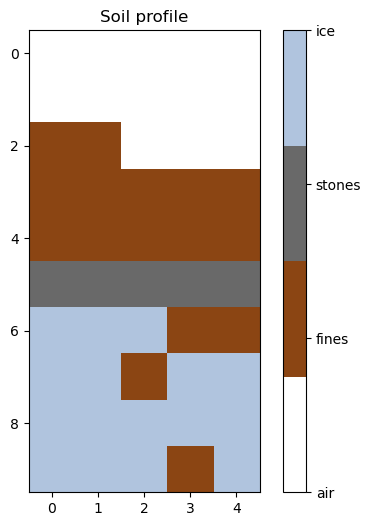

In [18]:
cmap,bounds = create_typecmap()
fig,ax = plot_typearr(viz_arr,cmap,bounds)

## Thawing cycle
1. Moving stones to top of fines column
2. Removing ice cells
3. Moving soils down to fill void space
4. Expansion and incorporation of void space
5. Stones and fines toppling if angle of repose $>45 ^\circ $

In [19]:
safe_type_arr_pad = type_arr_new.copy()

### Move stones to top of soil column and remove ice
Steps 1-3 of thawing cycle. Equivalent to `soil sieving through stones' as per Kessler paper. 

In [20]:
for i in range(0,type_arr_new.shape[1]):
    column = type_arr_new[:,i]

    #find higest fine cell and all stones in column
    stone_idx = np.where(column=='s')[0]
    n_stones = len(stone_idx)
    highest_fine = np.where(column=='f')[0].min()

    #place stones to top and replace with air cell
    for i in range(0,n_stones):
        column[highest_fine-(i+1)] = 's'
        column[stone_idx[i]] = 'a'

    #replace all ice with air placeholder and move soil column down:
    column[column=='i'] ='a'
    mask = (column == 'f') | (column=='s')

    for i in range(len(column)-1,-1,-1):
        if mask[i] == True:
            t = column[i]
            new_idx = np.where(column=='a')[0].max() #find lowest void space
            column[new_idx] = t
            column[i] = 'a'
    # replace column in type array:
    type_arr_new[:,0] = column

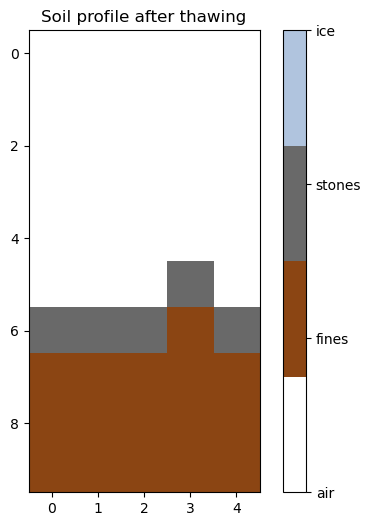

In [21]:
viz_arr_thawed = convert_typearr(type_arr_new)

fig,ax=plot_typearr(viz_arr_thawed,cmap,bounds,'Soil profile after thawing')

### 2. Add void spaces back in

In [22]:
void_counter = 0 
kernel = compressibility*np.ones((3,3))

while void_counter <= n_voids: #loop until enough voids are added
    # create new mask array from type array
    mask = (type_arr_new == 'f').astype(int) 
    prob_arr = convolve2d(mask,kernel,boundary='symm')[1:-1,1:-1]/9 *mask
    rand_arr = np.random.rand(prob_arr.shape[0],prob_arr.shape[1])

    void_idx = np.where(rand_arr <= prob_arr) # add voids where probability array 
    void_idx = list(zip(void_idx[0],void_idx[1]))
    np.random.shuffle(void_idx) # shuffle index list to avoid bias through how np.where adds indices

    for i in range(len(void_idx)):
        void_counter += 1
        if void_counter <= n_voids: # only add void if needed
            v = void_idx[i]
            full_column = type_arr_new[:,v[1]].copy()
            top_column = type_arr_new[:v[0]+1,v[1]].copy()
            idx_up = np.where(top_column !='a')[0] #indices of cells to move up in column
            for i in idx_up:
                full_column[i-1] = full_column[i]
            full_column[v[0]] = 'v'
            type_arr_new[:,v[1]] = full_column
        else:
            break
        

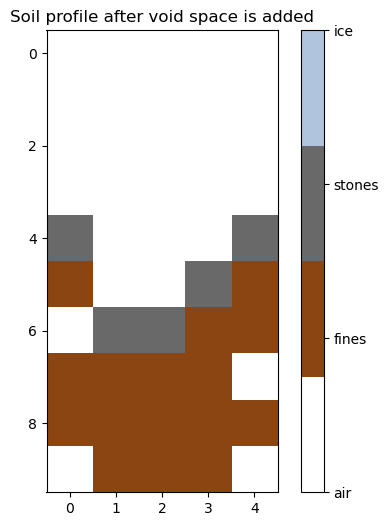

In [23]:
viz_arr = convert_typearr(type_arr_new)
fig,ax=plot_typearr(viz_arr,cmap,bounds,'Soil profile after void space is added')

### Toppling of stones
Simulate surface relaxation by moving stones downslope if more than angle is steeper than $45^\circ$.

In [38]:
mask = (type_arr_new == 's') | (type_arr_new == 'f')
mask

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [ True, False, False, False,  True],
       [ True, False, False,  True,  True],
       [False,  True,  True,  True,  True],
       [ True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [False,  True,  True,  True, False]])

In [58]:
#find top of soil column in each column:
top_x = []
top_y = []

for i in range(0,type_arr_new.shape[1]):
    # find highest stone or fine in column
    column = mask[:,i]
    highest = np.where(column == True)[0].min()
    top_x.append(i)
    top_y.append(highest)

top_x = np.array(top_x)
top_y = np.array(top_y)

#calculate distance to neighbouring columns
for i in range(len(top_y)):
    # find neighbouring columns in array; when extending to 3D, need to test in all horizontal directions
    neighbour_idx = np.where(np.abs(top_x-top_x[i]) == 1)[0]
    for j in neighbour_idx:
        d = cart_distance((top_x[i],top_y[i]),(top_x[j],top_y[j])) #calculate distance between 
        print(d)


2.23606797749979
2.23606797749979
1.0
1.0
1.4142135623730951
1.4142135623730951
1.4142135623730951
1.4142135623730951
